# MRI Classification
*by Ali Lotfollahi*

## Libraries

In [30]:
import os

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import matplotlib.pyplot as plt

import numpy as np

## Parameters

In [31]:
DATA_LOCATION = 'dataset'
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
BATCH_SIZE = 8

LEARNING_RATE = 0.0001

### Cuda

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Custom Dataset

In [33]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def load_data(self):
        data = []
        for i, class_dir in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_dir)
            for file in os.listdir(class_path):
                file_path = os.path.join(class_path, file)
                data.append((file_path, i))
        return data

## Setting up DataLoader

In [34]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Grayscale(),
    # lambda img: img.expand(3, -1, -1),
    transforms.Normalize(0, 1),
    # transforms.Normalize((0, 0, 0), (1, 1, 1))
])

dataset = CustomDataset(root_dir=DATA_LOCATION, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

### Classes

In [35]:
classes = dataset.classes

### Initial Shape

In [36]:
image, _ = next(iter(dataset))
image.shape

torch.Size([1, 512, 512])

### Examples

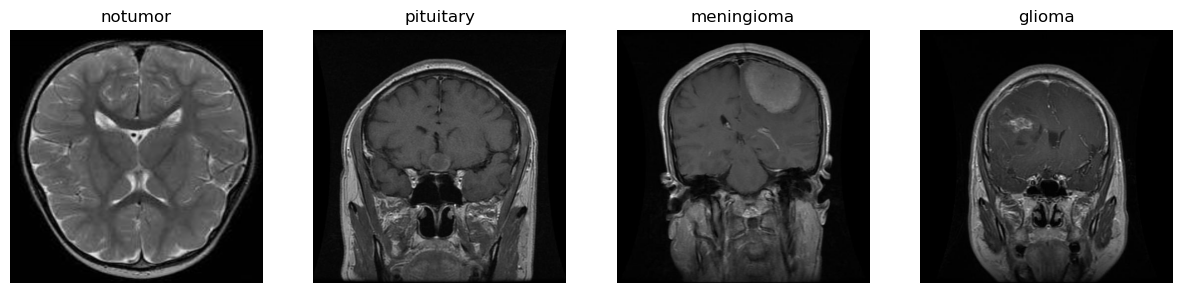

In [37]:
one_image_per_class = {}
for data, target in data_loader:
    if classes[target] not in one_image_per_class:
        one_image_per_class[classes[target]] = data.squeeze()
        if len(one_image_per_class) == len(classes):
            break

fig, axes = plt.subplots(nrows=1, ncols=len(classes))
fig.set_size_inches(15, 5)
for i, (class_name, image) in enumerate(one_image_per_class.items()):  
    ax = axes[i]
    
    image_grid = make_grid(image)
    ax.imshow(image_grid.permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
    ax.set_title(class_name)
plt.show()

## Breaking Data into Train and Test Sets

In [38]:
train_size = int(TRAIN_RATIO * len(dataset))
val_size = int(VAL_RATIO * len(dataset))
test_size = len(dataset) - train_size - val_size

train_size, val_size, test_size

(1048, 131, 132)

In [39]:
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

### Visualization

In [40]:
train_class_names = []
val_class_names = []
test_class_names = []
for _, target in train_set:
    train_class_names.append(classes[target])
for _, target in val_set:
    val_class_names.append(classes[target])
for _, target in test_set:
    test_class_names.append(classes[target])

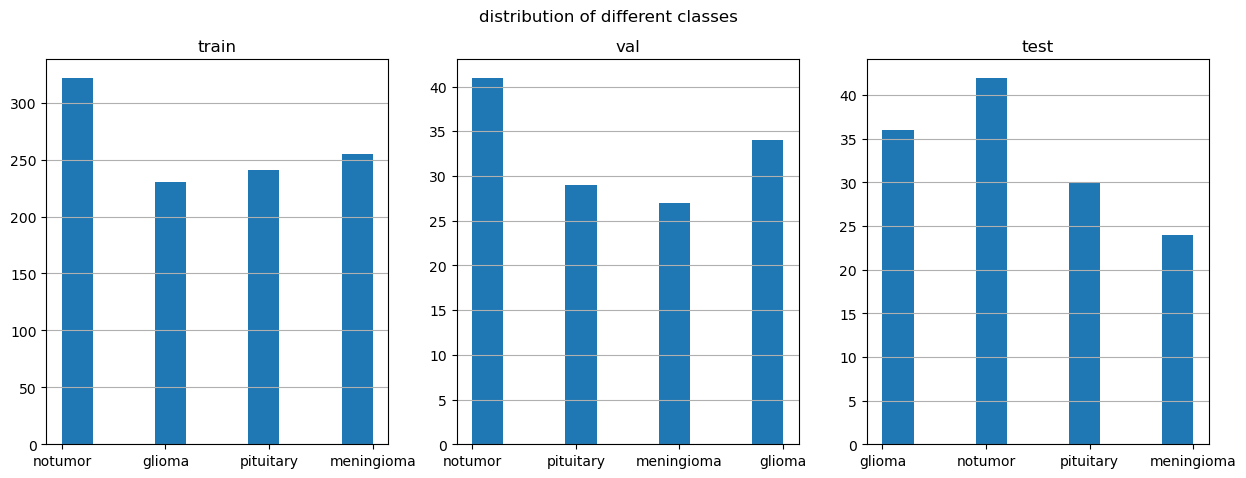

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 5)
fig.suptitle('distribution of different classes')
cols = ['train', 'val', 'test']
for i, col in enumerate(cols):
    axes[i].hist(eval(f"{col}_class_names"))
    axes[i].set_title(col)
    axes[i].grid(axis='y')
plt.show()

## Design of the CNN

In [42]:
print(f"Number of batches in the training set: {int(train_size / BATCH_SIZE)}")
print(f"Number of batches in the validation set: {int(val_size / BATCH_SIZE)}")
print(f"Number of batches in the testing set: {int(test_size / BATCH_SIZE)}")

Number of batches in the training set: 131
Number of batches in the validation set: 16
Number of batches in the testing set: 16


In [43]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [44]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = []
        
        n_conv = 7
        in_channels =   [1,     16,     32,    64,      128,    256,    512 ]
        out_channels =  [16,    32,     64,    128,     256,    512,    1024]
        dim = 512
        for i in range(n_conv):
            exec(f"self.conv{i + 1} = nn.Conv2d(in_channels=in_channels[i], out_channels=out_channels[i], kernel_size=3)")
            self.layers.append(('conv', eval(f"self.conv{i + 1}")))
            dim -= 3 - 1
            
            exec(f"self.pool{i + 1} = nn.MaxPool2d(kernel_size=2, stride=2)")
            self.layers.append(('pool', eval(f"self.pool{i + 1}")))
            dim //= 2            
            
        self.flatten = nn.Flatten()
        self.layers.append(('flatten', self.flatten))
        
        n_fc = 2
        in_features =   [out_channels[-1] * dim * dim,  512]
        out_features =  [512,                          512]
        for i in range(n_fc):
            exec(f"self.fc{i + 1} = nn.Linear(in_features=in_features[i], out_features=out_features[i])")
            self.layers.append(('fc', eval(f"self.fc{i + 1}")))
            if i == n_fc - 1:
                continue
            exec(f"self.drop{i + 1} = nn.Dropout(p=0.3)")
            self.layers.append(('drop', eval(f"self.drop{i + 1}")))
            
        self.out = nn.Linear(in_features=out_features[-1], out_features=len(classes))
        self.layers.append(('out', self.out))
        
    def forward(self, x):
        for type, layer in self.layers:
            x = layer(x)
            if type == 'conv' or type == 'fc':
                x = F.relu(x)
        return x

### Instantiation

In [45]:
cnn = CNN()
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (pool7): MaxPool2d(kernel_size=2, stride=2,

In [46]:
n_params = 0
for param in cnn.parameters():
    n_params += len(torch.flatten(param))
print(f"Number of parameters in the model: {n_params:,}")

Number of parameters in the model: 8,654,468


In [47]:
for i, data in enumerate(train_loader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'inputs shape: {inputs.shape}')
    outputs = cnn(inputs)
    print(f'after network shape: {cnn(inputs).shape}')
    print(outputs[0])
    break

inputs shape: torch.Size([8, 1, 512, 512])


after network shape: torch.Size([8, 4])
tensor([-0.0201, -0.0505,  0.0318, -0.0202], grad_fn=<SelectBackward0>)


### Loss Function

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

### Training

In [49]:
def train_one_epoch():
    cnn.train(True)
    
    running_loss = 0.
    running_accuracy = 0.
    
    for batch_index, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = cnn(inputs) # shape: [batch_size, #classes]
        
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        
        running_accuracy += correct / BATCH_SIZE
        
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if batch_index % 100 == 99: # every 100 batches
            avg_loss_across_batches = running_loss / 100
            avg_acc_across_batches = (running_accuracy / 100) * 100
            print(f"Batch: {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}, Accuracy: {avg_acc_across_batches:.1f}%")
            
            running_loss = 0.
            running_accuracy = 0.
            
    print()

In [50]:
def validate_one_epoch():
    cnn.train(False)
    
    running_loss = 0.
    running_accuracy = 0.
    
    for batch_index, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            outputs = cnn(inputs) # shape: [batch_size, #classes]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            
            running_accuracy += correct / BATCH_SIZE
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(val_loader)
    avg_acc_across_batches = (running_accuracy / len(val_loader)) * 100
    print(f"Validation Loss: {avg_loss_across_batches:.3f}, Validation Accuracy: {avg_acc_across_batches:.1f}%")
    
    print('*' * 30)
    print()

In [51]:
n_epochs = 10

for epoch_index in range(n_epochs):
    print(f"Epoch: {epoch_index + 1}\n")
    
    train_one_epoch()
    validate_one_epoch()
    
print('Training Finished!')

Epoch: 1


Validation Loss: 1.314, Validation Accuracy: 46.3%
******************************

Epoch: 2


Validation Loss: 1.107, Validation Accuracy: 47.1%
******************************

Epoch: 3



KeyboardInterrupt: 